In [109]:
import pickle

import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd

from constants import (
    TRAIN_DATA_CSV,
    TEST_DATA_CSV,
    TEST_IMAGE_FEATURES_PATH,
    TEST_TEXT_FEATURES_PATH,
    TRAIN_IMAGE_FEATURES_PATH,
    TRAIN_TEXT_FEATURES_PATH,
    MULTIMODAL_MODEL_PATH,
    TARGET_SCALER_PATH,
)
from core.src.utils.metrics import compute_metrics
from core.src.utils.plots import plot_loss_and_metrics, print_metrics_table

In [110]:
df_train = pd.read_csv(TRAIN_DATA_CSV, dtype={"unique_id": str})
df_test = pd.read_csv(TEST_DATA_CSV, dtype={"unique_id": str})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(TARGET_SCALER_PATH, "rb") as f:
    target_scaler = pickle.load(f)

In [111]:
df_train.head()

,km,putere,capacitate cilindrica,anul producției,marca,model,combustibil,tip caroserie,price,price_std,firma,is_automatic,input,unique_id
0,-1.765987,0.707815,0.300962,-1.617745,-0.511087,0.514843,-1.702806,1.073929,32500,2.021545,1,1,"audio si tehnologie: apple carplay,android aut...",031864
1,-1.131364,-0.302239,-0.501443,-0.691204,0.001912,0.199539,0.587266,1.073929,20950,0.725453,1,1,"audio si tehnologie: apple carplay,android aut...",003886
2,-1.202597,-0.788562,-1.330871,-0.922839,-1.144629,-1.020018,-1.702806,-1.355370,12490,-0.223892,1,1,"audio si tehnologie: apple carplay,android aut...",034501
3,-0.315419,-0.601514,-0.707241,-0.922839,-0.657634,-0.877688,0.587266,-1.355370,9550,-0.553806,0,0,"audio si tehnologie: android auto,bluetooth,ra...",018118
4,-1.649424,-0.695038,-0.786234,-0.922839,-0.964147,-0.570761,0.587266,1.073929,18390,0.438181,1,1,"audio si tehnologie: apple carplay,android aut...",012133


In [112]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25422 entries, 0 to 25421
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   km                     25422 non-null  float64
 1   putere                 25422 non-null  float64
 2   capacitate cilindrica  25422 non-null  float64
 3   anul producției        25422 non-null  float64
 4   marca                  25422 non-null  float64
 5   model                  25422 non-null  float64
 6   combustibil            25422 non-null  float64
 7   tip caroserie          25422 non-null  float64
 8   price                  25422 non-null  int64  
 9   price_std              25422 non-null  float64
 10  firma                  25422 non-null  int64  
 11  is_automatic           25422 non-null  int64  
 12  input                  25422 non-null  object 
 13  unique_id              25422 non-null  object 
dtypes: float64(9), int64(3), object(2)
memory usage: 2.7+ 

In [113]:
STRUCTURED_COLUMNS = [
    "km",
    "putere",
    "capacitate cilindrica",
    "anul producției",
    "marca",
    "model",
    "combustibil",
    "tip caroserie",
    "firma",
    "is_automatic",
]

train_structured_data = df_train[STRUCTURED_COLUMNS].to_numpy()
test_structured_data = df_test[STRUCTURED_COLUMNS].to_numpy()

train_targets = df_train["price_std"].to_numpy()
test_targets = df_test["price_std"].to_numpy()

train_structured_data.shape, test_structured_data.shape, train_targets.shape, test_targets.shape

((25422, 10), (6356, 10), (25422,), (6356,))

In [114]:
train_image_features = np.load(TRAIN_IMAGE_FEATURES_PATH)
test_image_features = np.load(TEST_IMAGE_FEATURES_PATH)

train_text_features = np.load(TRAIN_TEXT_FEATURES_PATH)
test_text_features = np.load(TEST_TEXT_FEATURES_PATH)

len(train_image_features), len(train_text_features), len(test_image_features), len(test_text_features)

(25422, 25422, 6356, 6356)

In [115]:
class MultimodalDataset(Dataset):
    def __init__(self, image_features, text_features, structured_data, targets):
        self.image_features = image_features
        self.text_features = text_features
        self.structured_data = structured_data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = torch.tensor(self.image_features[idx], dtype=torch.float32)
        text = torch.tensor(self.text_features[idx], dtype=torch.float32)

        structured = torch.tensor(self.structured_data[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        features = torch.cat([image, text, structured])

        return features, target


train_dataset = MultimodalDataset(train_image_features, train_text_features, train_structured_data, train_targets)
test_dataset = MultimodalDataset(test_image_features, test_text_features, test_structured_data, test_targets)

BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainSteps = len(train_loader.dataset) // BATCH_SIZE
testSteps = len(test_loader.dataset) // BATCH_SIZE
history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

In [116]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1546, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


model = Net().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, min_lr=1e-9, patience=100)

In [117]:
best_val_loss = float("inf")
for epoch in range(2000):
    model.train()
    train_loss = 0.0
    all_train_predictions = []
    all_train_ground_truths = []

    for features, target in train_loader:
        features = features.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, target.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)

        outputs = outputs.cpu().detach().numpy()
        target = target.view(-1, 1).cpu().detach().numpy()

        unnorm_outputs = target_scaler.inverse_transform(outputs)
        unnorm_target = target_scaler.inverse_transform(target)

        all_train_predictions.extend(unnorm_outputs)
        all_train_ground_truths.extend(unnorm_target)

    train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
    metrics_history["train_mae"].append(train_metrics["MAE"])
    metrics_history["train_mse"].append(train_metrics["MSE"])
    metrics_history["train_rmse"].append(train_metrics["RMSE"])
    metrics_history["train_r2"].append(train_metrics["R2"])

    # Validation loop (optional, but recommended)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        all_test_predictions = []
        all_test_ground_truths = []
        for features, target in test_loader:
            features = features.to(device)
            target = target.to(device)
            outputs = model(features)
            loss = criterion(outputs, target.view(-1, 1))  # Ensure 'target' is defined for test data
            test_loss += loss.item() * features.size(0)

            outputs = outputs.cpu().detach().numpy()
            target = target.view(-1, 1).cpu().detach().numpy()

            unnorm_outputs = target_scaler.inverse_transform(outputs)
            unnorm_target = target_scaler.inverse_transform(target)

            all_test_predictions.extend(unnorm_outputs)
            all_test_ground_truths.extend(unnorm_target)

        test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
        metrics_history["test_mae"].append(test_metrics["MAE"])
        metrics_history["test_mse"].append(test_metrics["MSE"])
        metrics_history["test_rmse"].append(test_metrics["RMSE"])
        metrics_history["test_r2"].append(test_metrics["R2"])

        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)

        history["test_loss"].append(test_loss)
        history["train_loss"].append(train_loss)

        scheduler.step(test_loss)
        print(scheduler.get_last_lr())

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print("Train Metrics: ", train_metrics)
        print("Test Metrics: ", test_metrics)

        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save(model.state_dict(), MULTIMODAL_MODEL_PATH)
            print(f"Epoch {epoch + 1}: New best test loss: {best_val_loss}")

[5e-05]
Epoch 1, Train Loss: 0.6526, Test Loss: 0.4810
Train Metrics:  {'MAE': 5815.1655, 'MSE': 62326220.0, 'RMSE': 7894.696, 'R2': 0.21176564334697034}
Test Metrics:  {'MAE': 4286.799, 'MSE': 40099040.0, 'RMSE': 6332.3804, 'R2': 0.4934774304294741}
Epoch 1: New best test loss: 0.4810461615375785
[5e-05]
Epoch 2, Train Loss: 0.4237, Test Loss: 0.3522
Train Metrics:  {'MAE': 3775.8496, 'MSE': 30311482.0, 'RMSE': 5505.5864, 'R2': 0.6166532499406654}
Test Metrics:  {'MAE': 3138.5247, 'MSE': 20189524.0, 'RMSE': 4493.2754, 'R2': 0.744970196950296}
Epoch 2: New best test loss: 0.35219176922900786
[5e-05]
Epoch 3, Train Loss: 0.3602, Test Loss: 0.3115
Train Metrics:  {'MAE': 3209.492, 'MSE': 20243392.0, 'RMSE': 4499.2656, 'R2': 0.7439835763284585}
Test Metrics:  {'MAE': 2775.6953, 'MSE': 15740244.0, 'RMSE': 3967.3977, 'R2': 0.8011725659667985}
Epoch 3: New best test loss: 0.31147663018626937
[5e-05]
Epoch 4, Train Loss: 0.3323, Test Loss: 0.2957
Train Metrics:  {'MAE': 2961.3418, 'MSE': 1675

KeyboardInterrupt: 

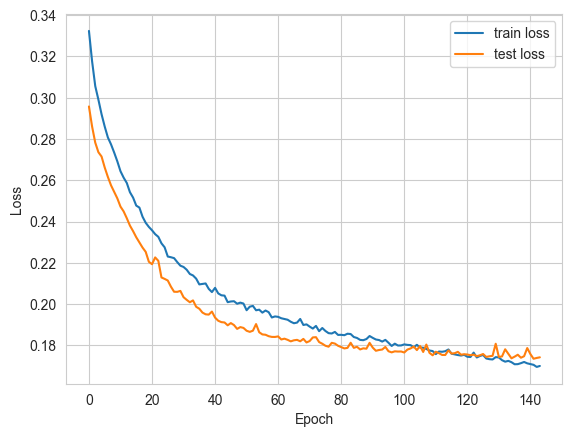

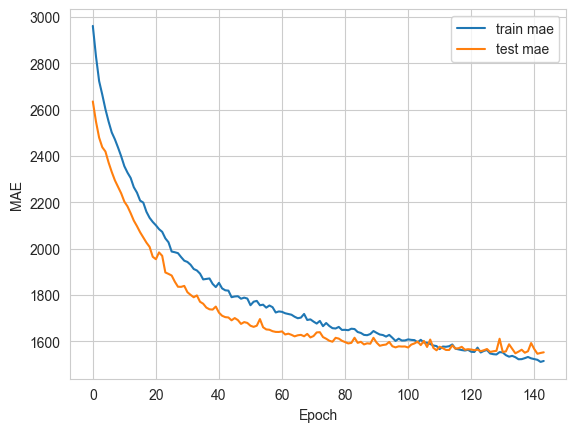

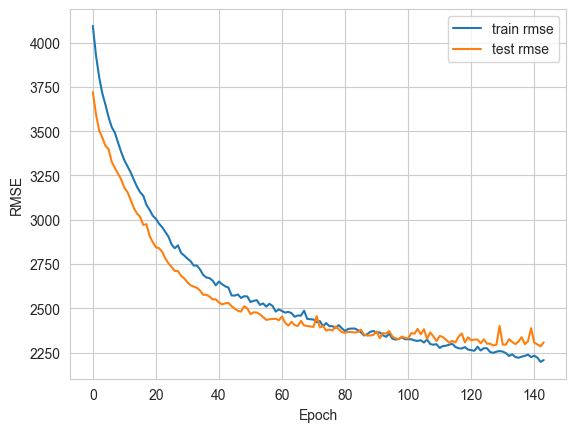

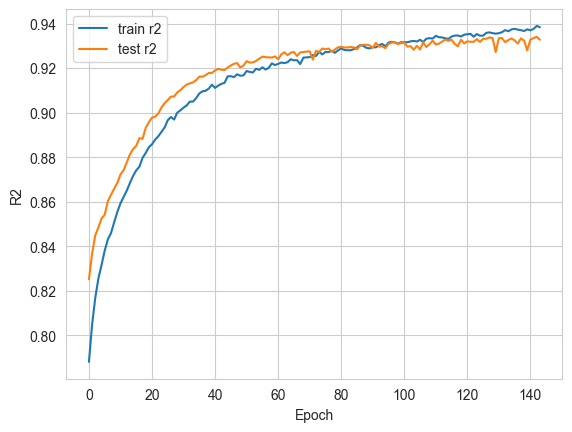

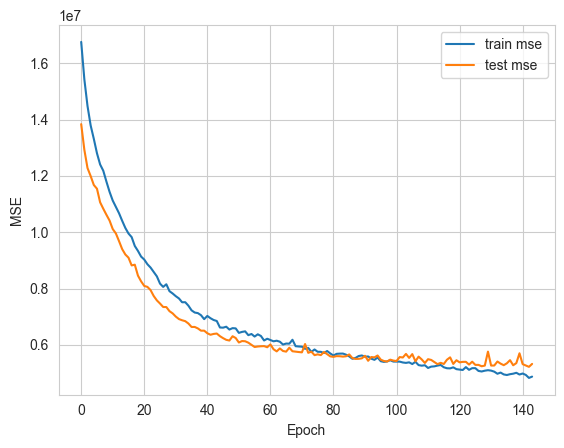

Train Metrics
+---------+--------+---------+---------+-------------+
|   Epoch |    MAE |    RMSE |      R2 |         MSE |
+=========+========+=========+=========+=============+
|     146 | 1515.3 | 2207.77 | 0.93836 | 4.87426e+06 |
+---------+--------+---------+---------+-------------+

Test Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|     146 | 1552.64 | 2307.73 | 0.93273 | 5.32561e+06 |
+---------+---------+---------+---------+-------------+


In [118]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=3)
print_metrics_table(metrics_history)